In [1]:
import hdcms as hdc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

In [2]:
# the data for ex[i].txt (maybe convert to reading in from numpy)
a = np.array([0.19274193548387097,   0.14073226544622425,
0.6556451612903226,   0.34439359267734554,
1.1451612903225807,   0.18707093821510298,
0.15483870967741936,   0.18020594965675057,
0.6645161290322581,   0.36784897025171626,
1.15,   0.17963386727688788,
0.11290322580645161,   0.10469107551487414,
0.6588709677419354,   0.33752860411899316,
1.1516129032258065,   0.17734553775743708,
0.28951612903225804,   0.06807780320366133,
0.6645161290322581,   0.3197940503432494,
1.153225806451613,   0.17963386727688788,
0.31209677419354837,   0.16018306636155608,
0.6725806451612903,   0.3329519450800915,
1.1556451612903227,   0.17162471395881007,
0.07580645161290323,   0.15846681922196795,
0.6612903225806451,   0.29576659038901604,
1.1556451612903227,   0.17963386727688788,
0.0846774193548387,   0.04004576659038902,
0.6645161290322581,   0.32151029748283755,
1.1596774193548387,   0.17848970251716248]).reshape(-1, 2)
# the colors for 
colors = ['red', 'green', 'blue', 
          'red', 'green', 'blue', 
          'red', 'green', 'blue', 
          'red', 'green', 'blue', 
          'red', 'green', 'blue', 
          'red', 'green', 'blue', 
          'red', 'green', 'blue']

In [3]:
sum_stat_2d = hdc.regex2stats2d(r"ex[0-9]+.txt", dir="./data/", scaling='n')
sum_stat_1d = hdc.regex2stats1d(r"ex[0-9]+.txt", dir="./data/", start=0, end=1.5, num_bins=15, scaling='n')
print(sum_stat_2d)

[[0.66313364 0.33139915 0.00536385 0.02250768]
 [1.15299539 0.17906178 0.00467265 0.00454076]
 [0.17465438 0.12177182 0.09529203 0.05236083]]


In [4]:
image_config = hdc.visualize.ImageConfig(size=(3600, 1200), std_scale=1, desingularization=1e-5, axis_thickness=3, xlabel="x values", ylabel="y values")
stats_context = hdc.visualize.StatsContext(start=0, stop=899.9, num_bins=9000)

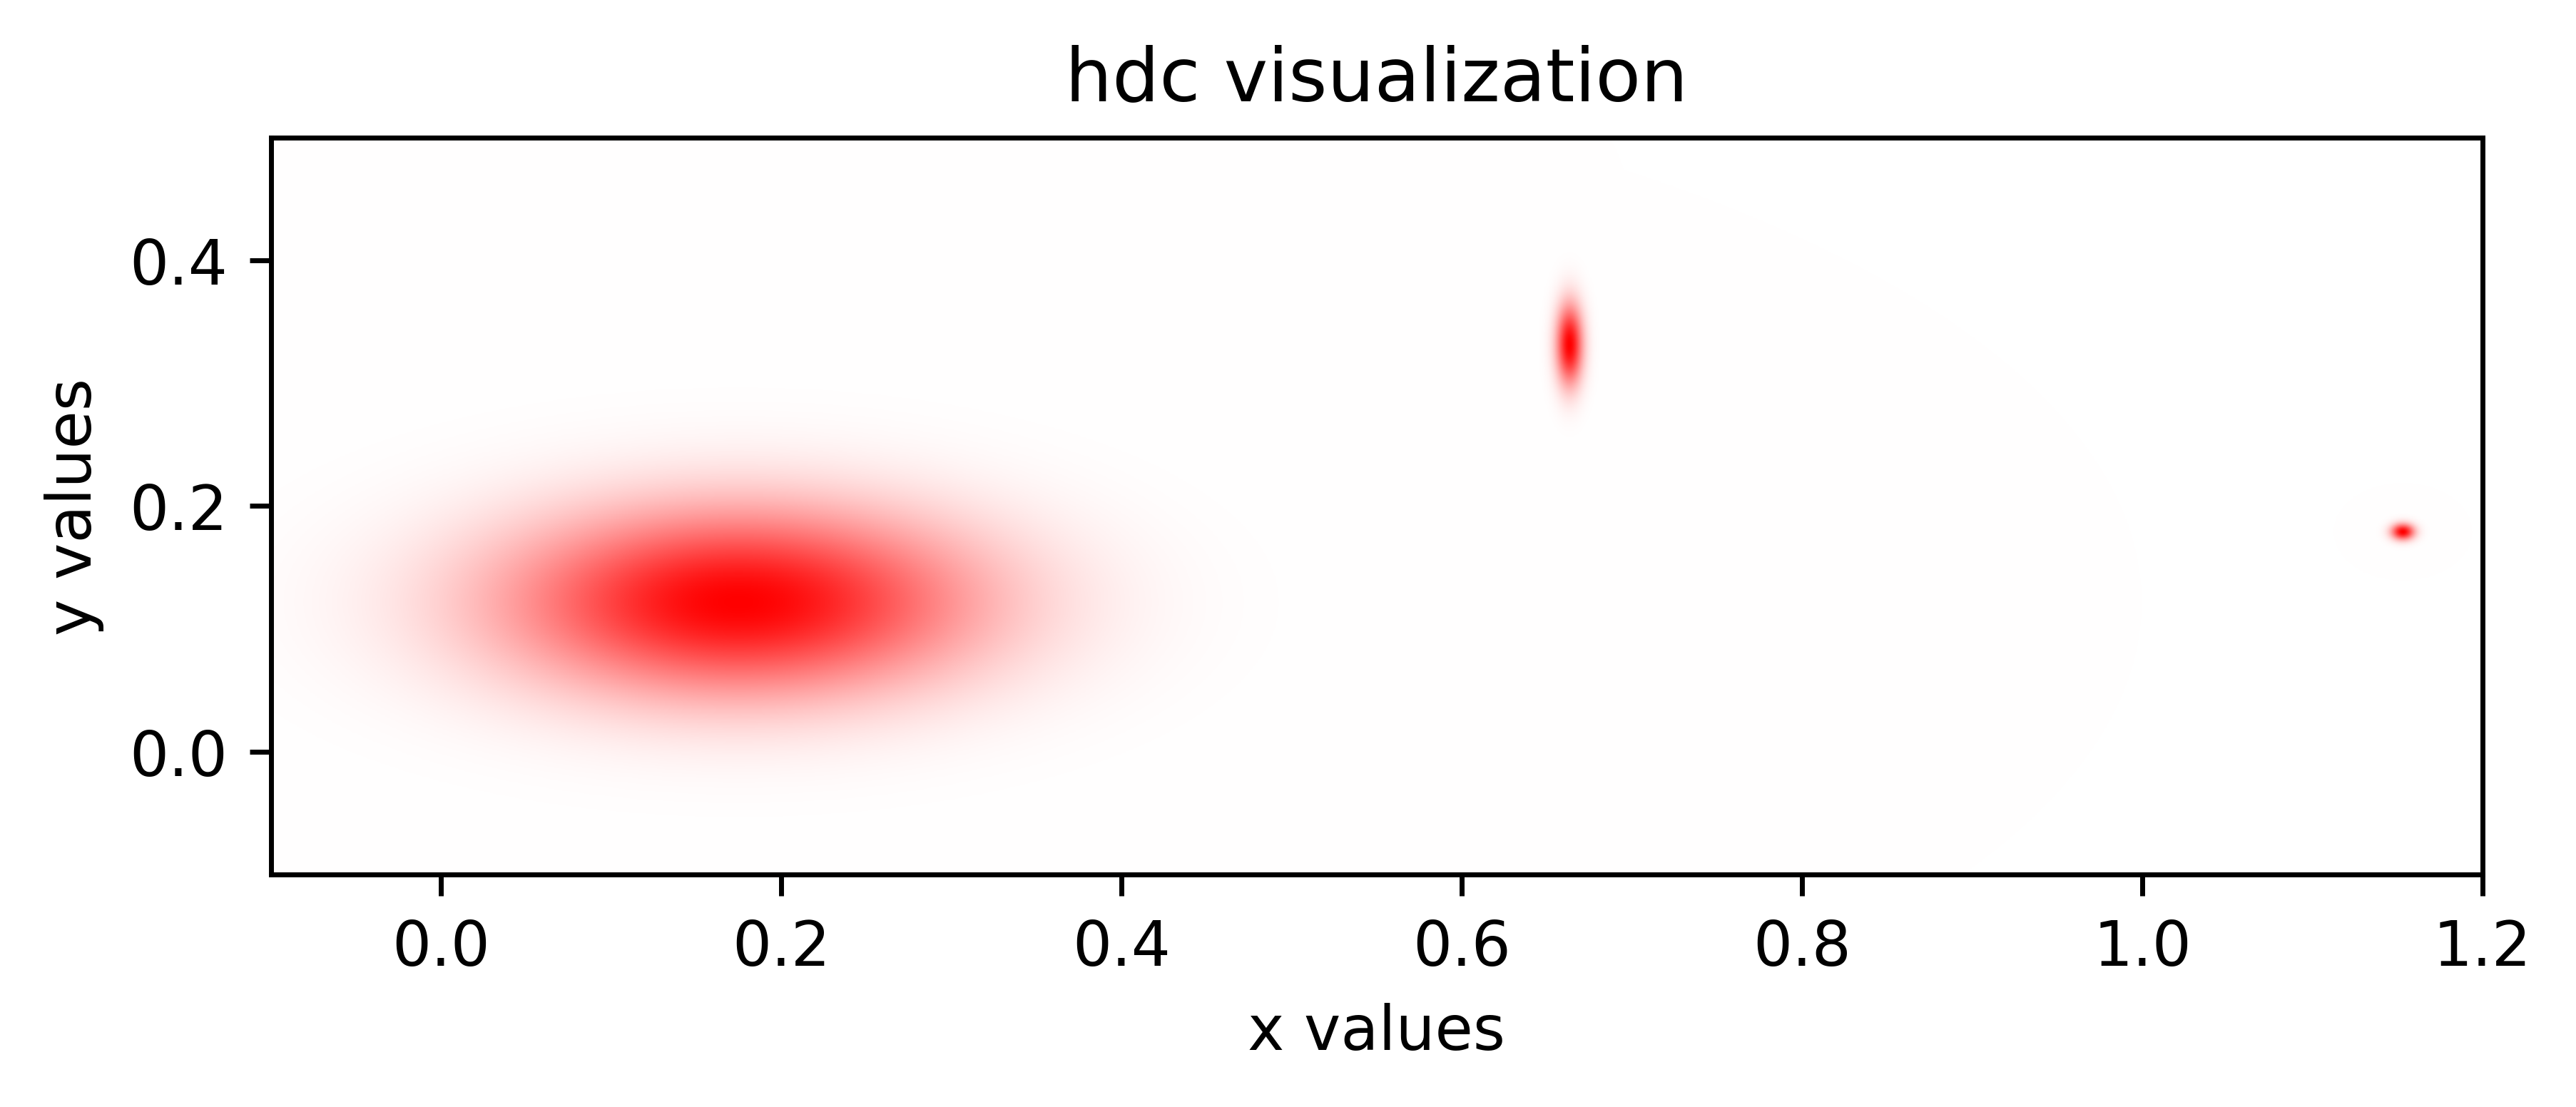

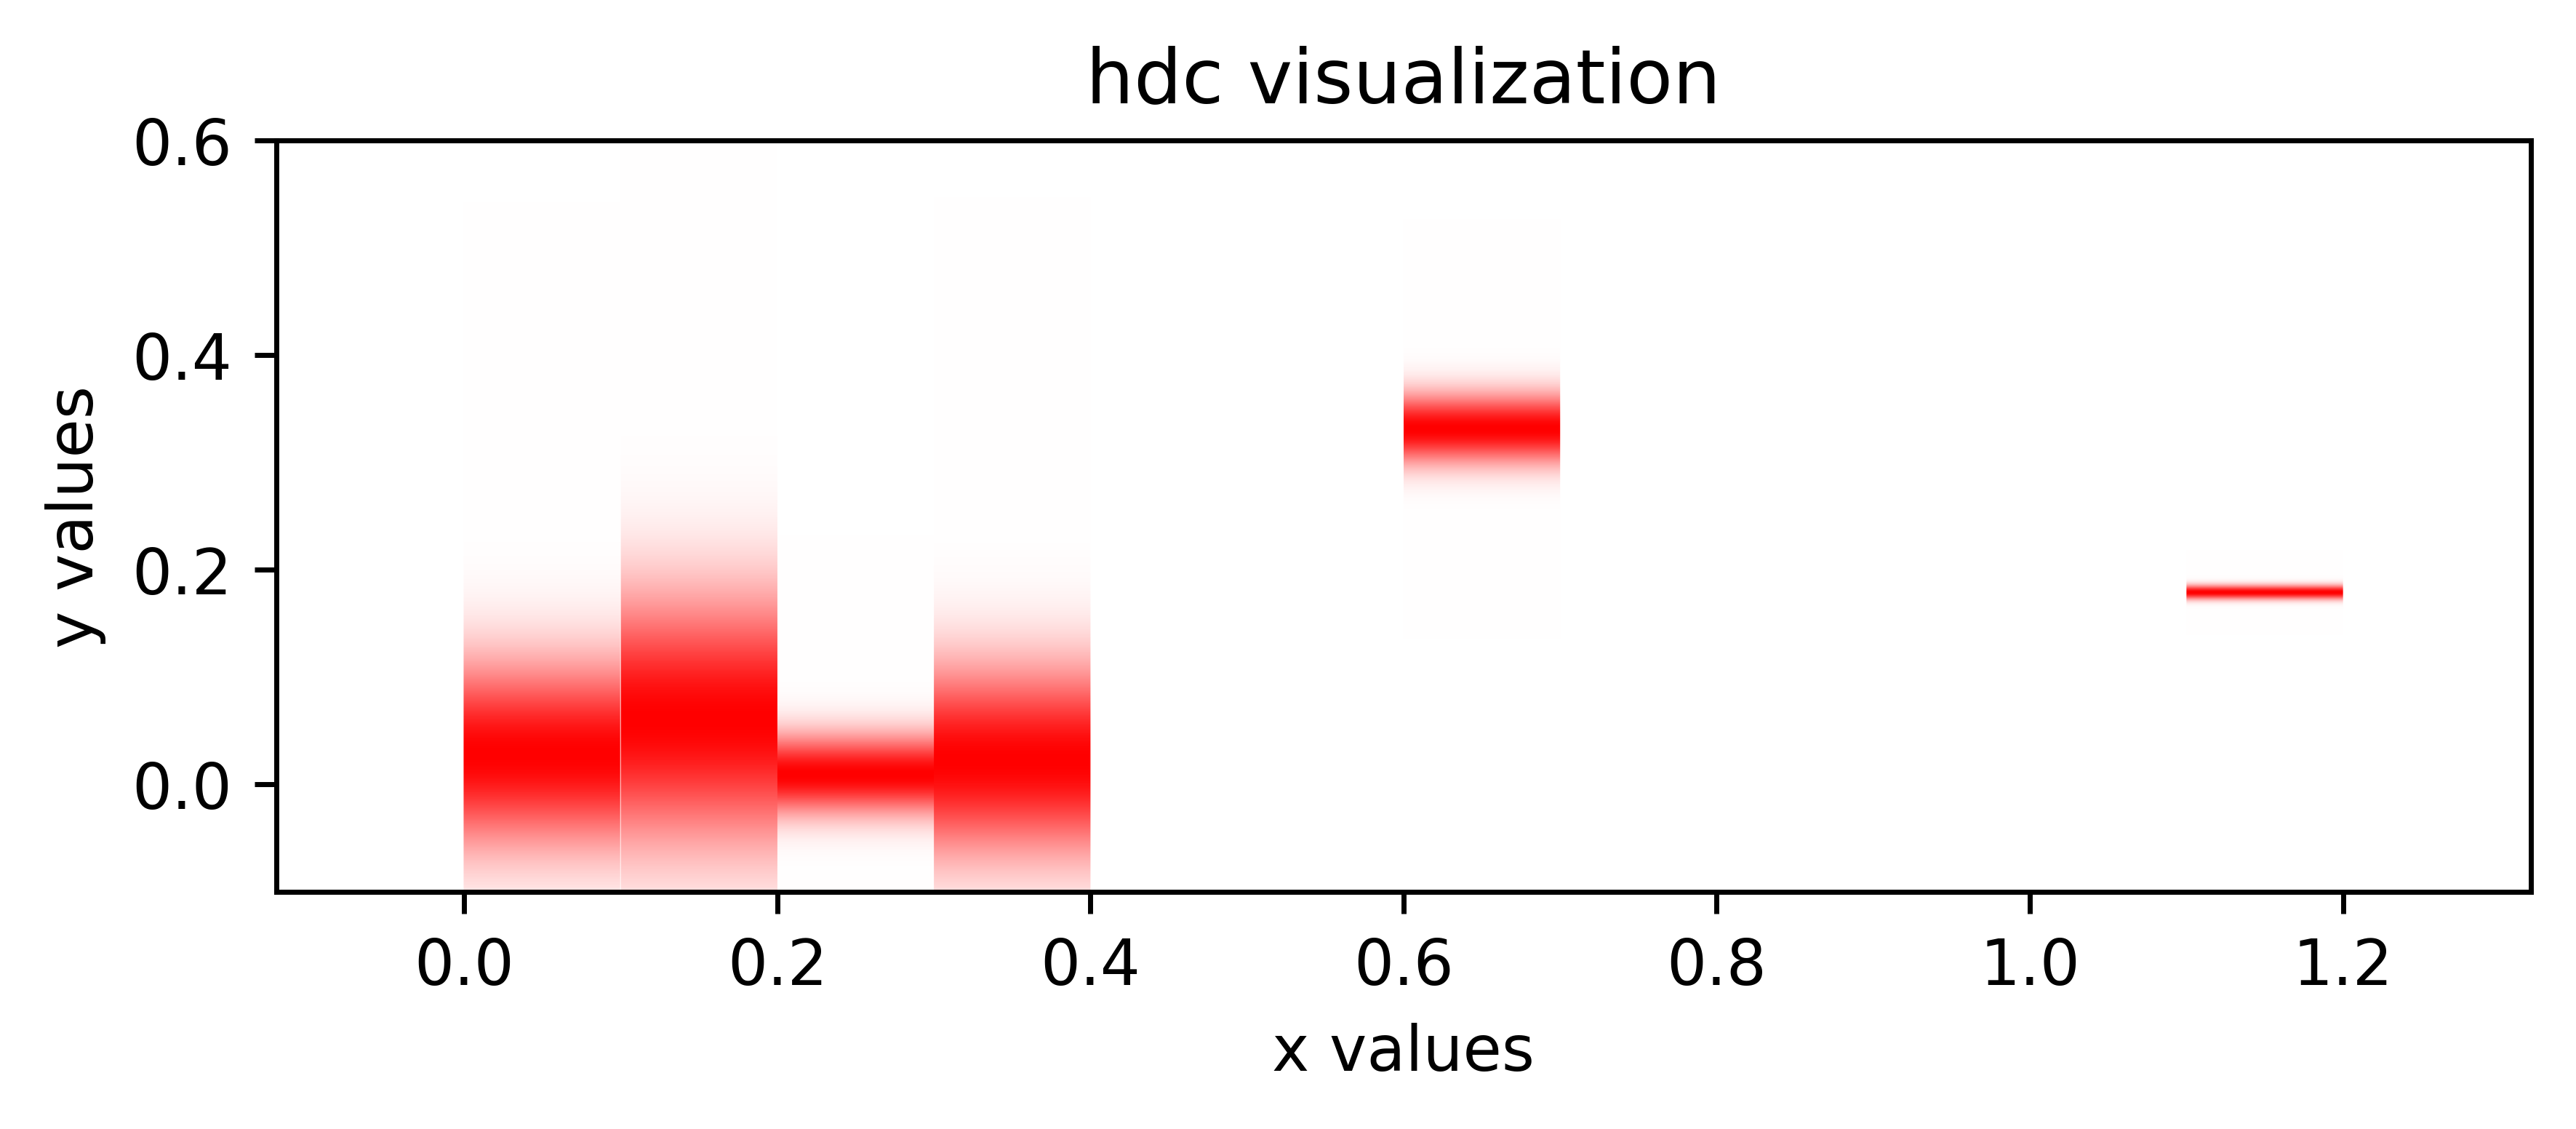

<Figure size 640x480 with 0 Axes>

In [5]:
# axis = (min_x, min_y, max_x, max_y)
twod_axis = (-0.1, -0.1, 1.2, 0.5)
im = hdc.write_image(sum_stat_2d, config=image_config, context=stats_context, axis_limits=twod_axis)
im.save("/tmp/output2.png")

oned_axis = (-0.12, -0.1, 1.32, 0.6)
im2 = hdc.write_image(sum_stat_1d, config=image_config, context=stats_context, axis_limits=oned_axis)
im2.save("/tmp/output1.png")

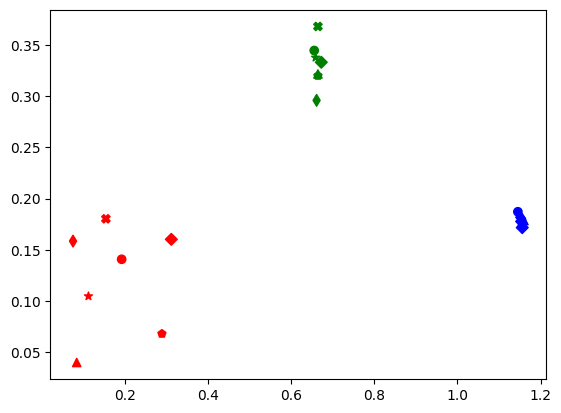

In [6]:
shapes = ['o', 'X', '*', 'p', 'D', 'd', '^']
for i in range(7):
    plt.scatter(x=a[i*3:i*3+3,0], y=a[i*3:i*3+3,1], c=colors[i*3:i*3+3], marker=shapes[i])
plt.show()

# Random stuff

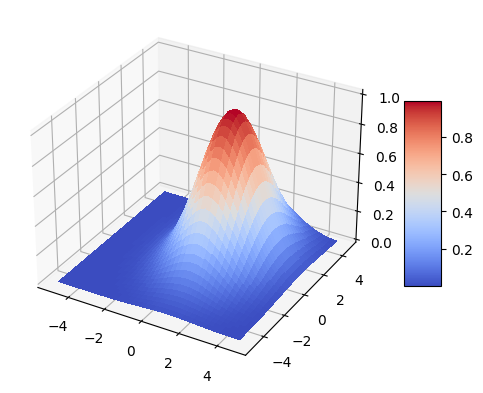

In [7]:
x = np.arange(-5, 5, .25)
y = np.arange(-5, 5, .25)
xv, yv = np.meshgrid(x, y)
r = ((xv-1)/2)**2 + ((yv-1)/3)**2
z = np.exp(-r)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xv, yv, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1.01)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("/tmp/3dgaussian.png")

# Custom colors

In [8]:
def write_image(data, colors, config=image_config, context=stats_context, axis_limits=None):
    data = np.array(data)
    if len(data[0]) == 4:
        data[:,2] = data[:,2] * config.std_scale + config.desingularization
        data[:,3] = data[:,3] * config.std_scale + config.desingularization
    elif len(data[0]) == 2:
        data[:,1] = data[:,1] * config.std_scale + config.desingularization
    else:
        raise RuntimeError(f"Incorrect dimension: recieved {data.shape} must be nx2 or nx4")

    # We need to auto adjust the axis limits if not provided
    if not axis_limits:
        yborder = 0.1
        xborder = 0.1

        if len(data[0]) == 4:
            width = np.max(data[:, 0]) - np.min(data[:, 0])
            height = np.max(data[:, 1]) - np.min(data[:, 1])
        else:
            width = (np.max(np.nonzero(data[:, 0])) + 1) * context.bin_width
            height = np.max(data[:, 0])
        # min_x, min_y, max_x, max_y
        axis_limits = (width * (-xborder), height * (-yborder), width * (1+xborder), height * (1+yborder))

    if len(data[0]) == 4:
        assert(np.min(data[:, 1]) >= 0 and np.min(data[:,0]) >= 0)

    img = np.ones((config.ypixels, config.xpixels, 3))

    for i, peak in enumerate(data):
        if len(peak) == 4:
            h, k, a, b = hdc.visualize.coordinate_rectangle_to_pixels(peak, axis_limits, config)
            red, green, blue = colors[i]
            img[:,:,0] -= (1-red) * hdc.visualize.gaussian_2d(config.xpixels, config.ypixels, h, k, a, b)
            img[:,:,1] -= (1-green) * hdc.visualize.gaussian_2d(config.xpixels, config.ypixels, h, k, a, b)
            img[:,:,2] -= (1-blue) * hdc.visualize.gaussian_2d(config.xpixels, config.ypixels, h, k, a, b)
        else:
            if np.sum(peak[0]) != 0.:
                rect_center_x = context.start + i*context.bin_width + context.bin_width/2
                h, k, width, sd = hdc.visualize.coordinate_rectangle_to_pixels((rect_center_x, peak[0], context.bin_width, peak[1]), axis_limits, config)
                r, g, b = colors[i]
                img[:,:,0] -= (1-r) * hdc.visualize.gaussian_1d(h, k, sd, width, config)
                img[:,:,1] -= (1-g) * hdc.visualize.gaussian_1d(h, k, sd, width, config)
                img[:,:,2] -= (1-b) * hdc.visualize.gaussian_1d(h, k, sd, width, config)

    img = hdc.visualize.dress_image(img, axis_limits, config)
    return Image.fromarray(img)

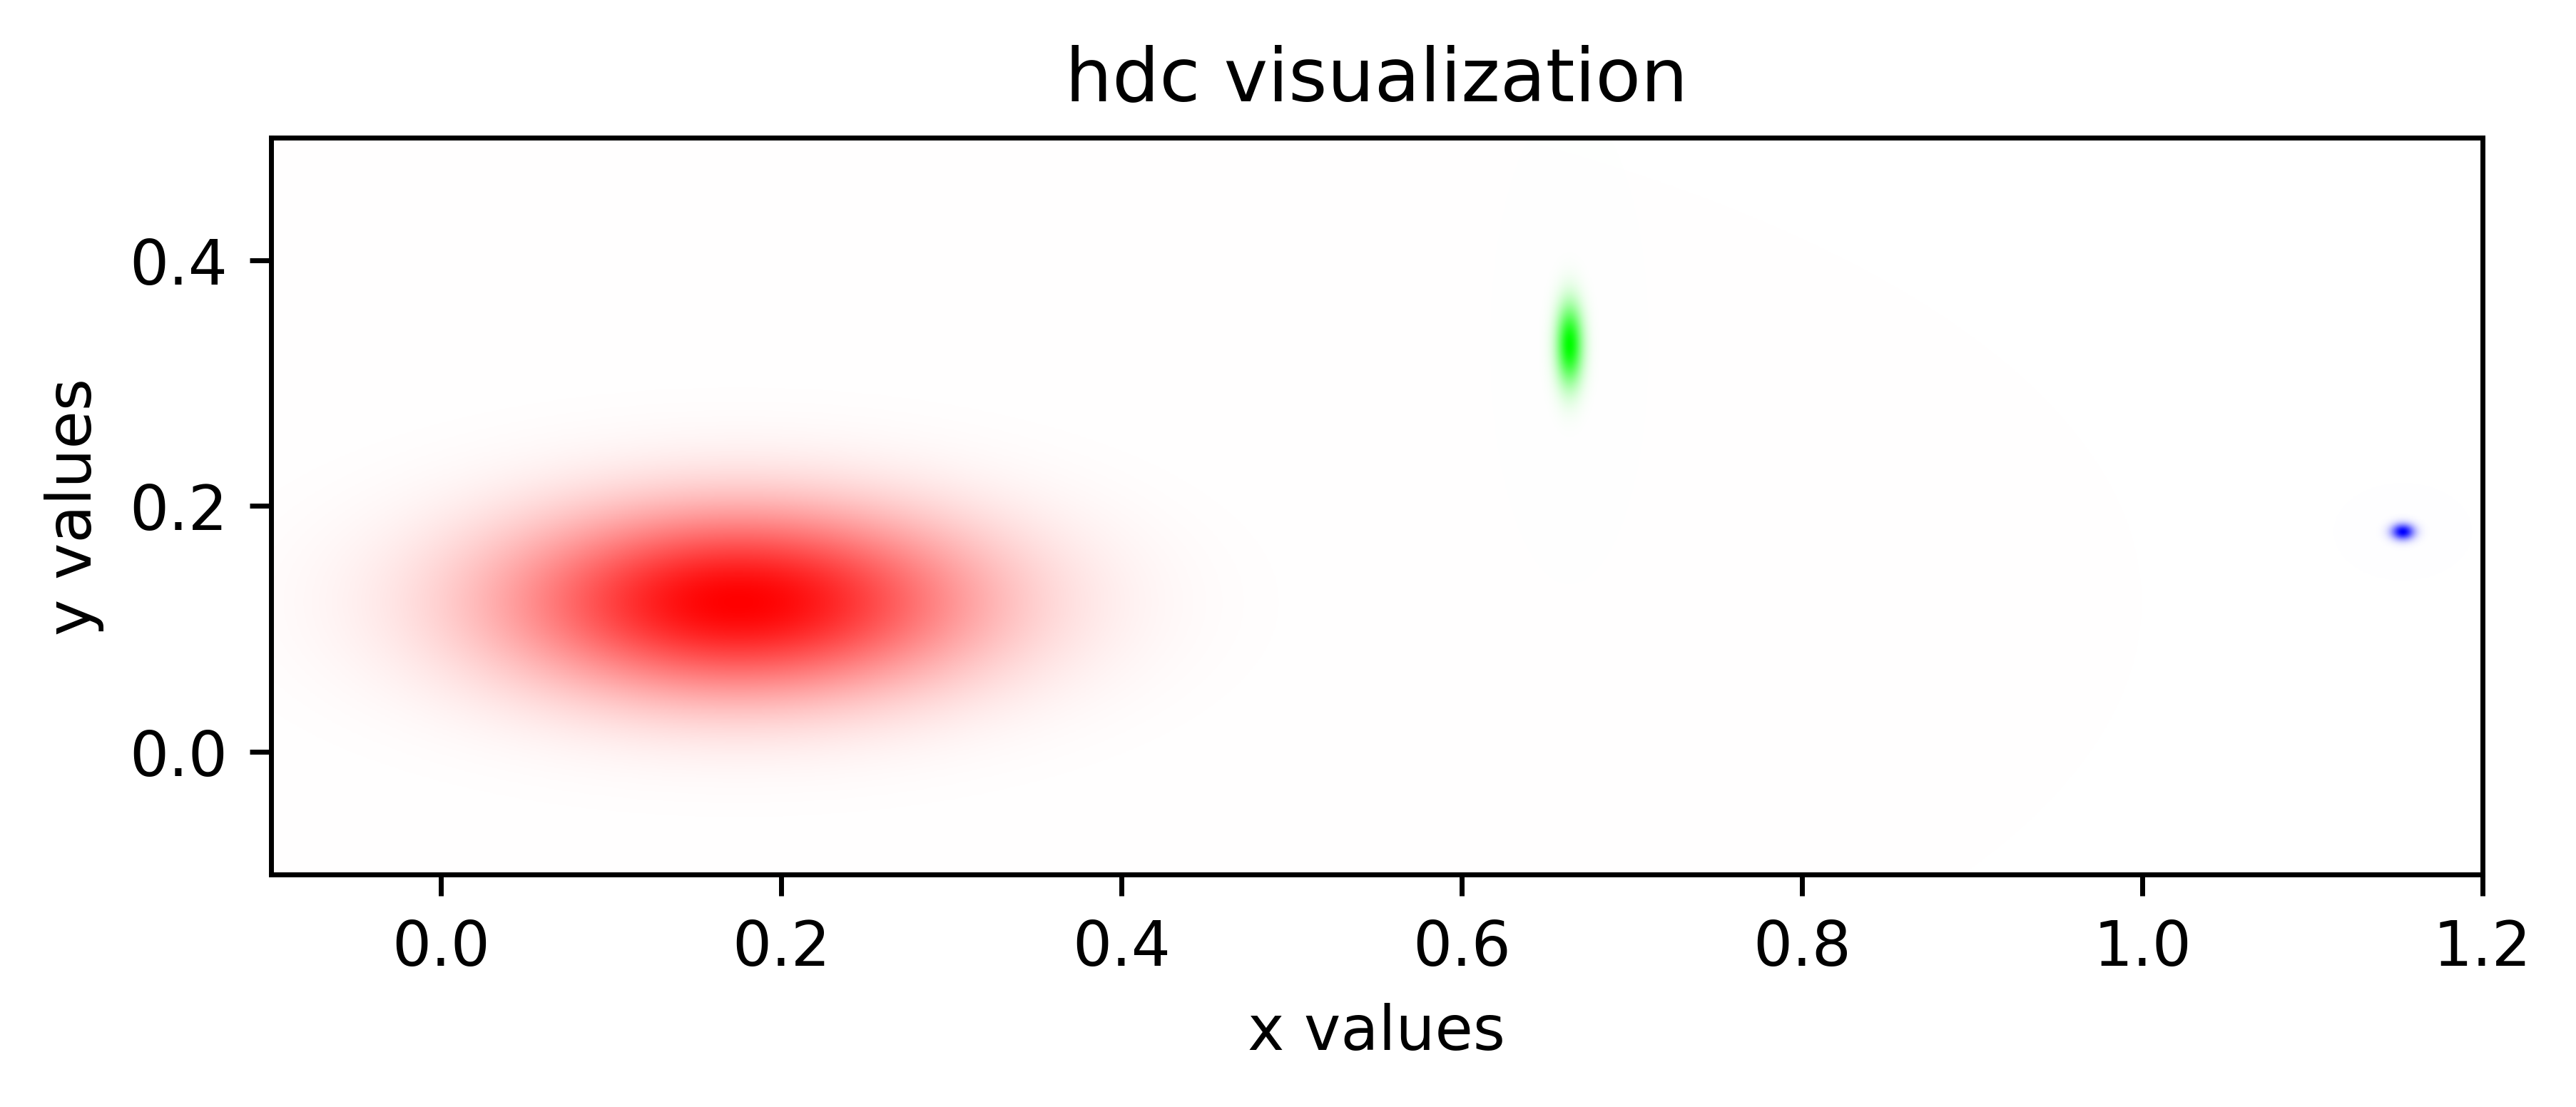

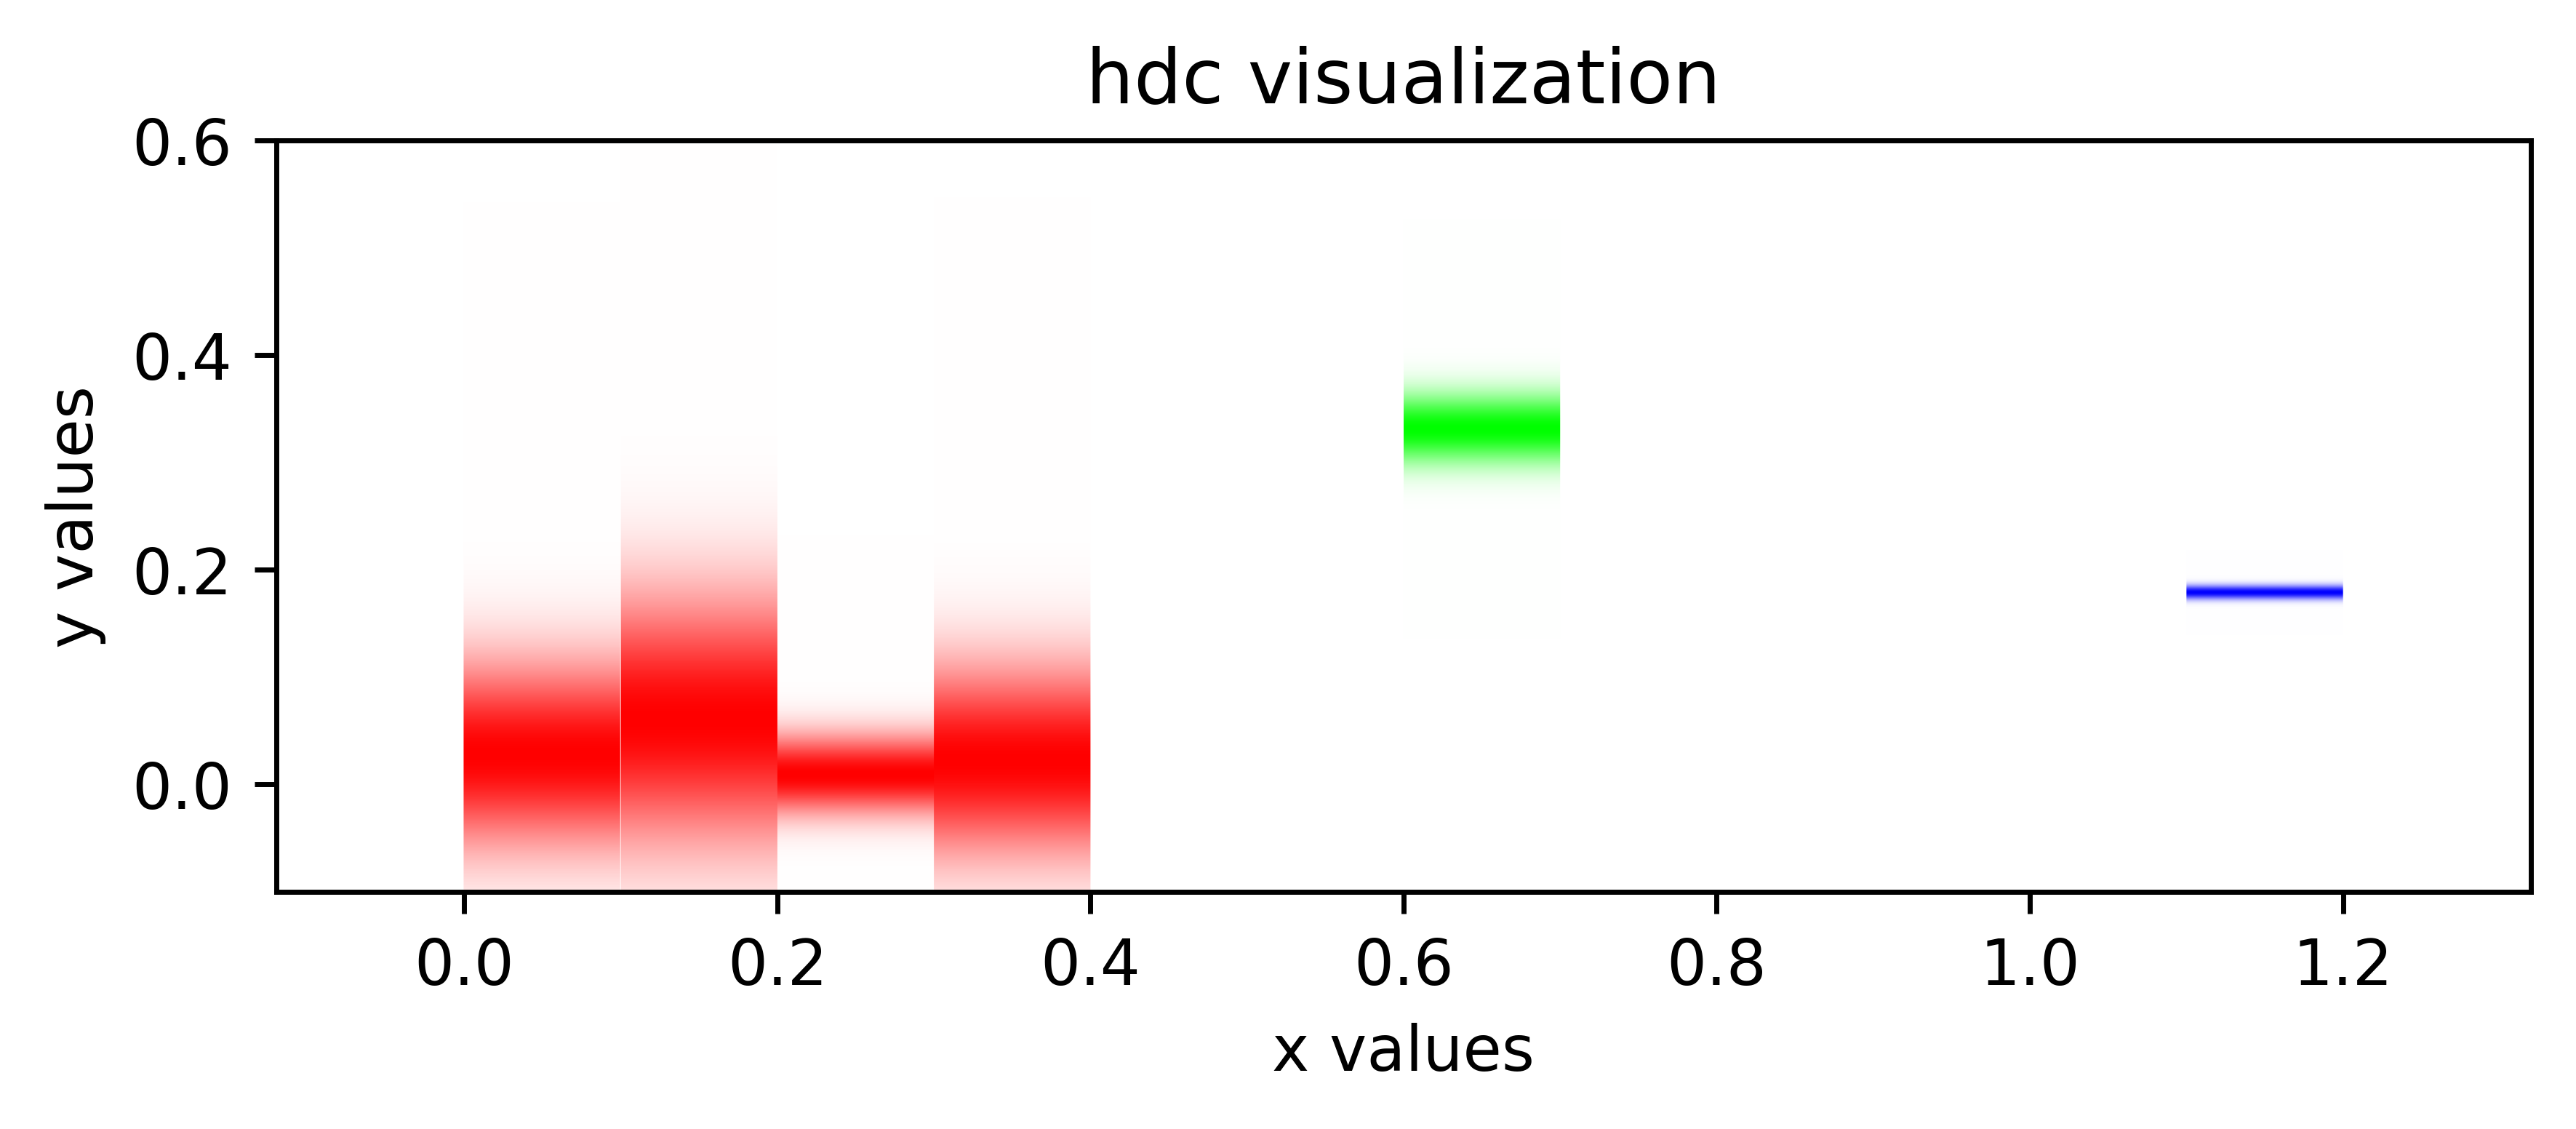

<Figure size 640x480 with 0 Axes>

In [9]:
r = (1, 0, 0)
g = (0, 1, 0)
b = (0, 0, 1)
w = (1, 1, 1)

# axis = (min_x, min_y, max_x, max_y)
twod_axis = (-0.1, -0.1, 1.2, 0.5)
im = write_image(sum_stat_2d, [g, b, r], config=image_config, context=stats_context, axis_limits=twod_axis)
im.save("/tmp/output2.png")

oned_axis = (-0.12, -0.1, 1.32, 0.6)
im2 = write_image(sum_stat_1d, [r]*4 + [w]*2 + [g] + [w]*4 + [b], config=image_config, context=stats_context, axis_limits=oned_axis)
im2.save("/tmp/output1.png")